In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=2)

import numpy as np
import pandas as pd

from astropy import constants as const
M_solar = const.M_sun.cgs.value
m_proton = const.m_p.cgs.value

# Read in my sample data

In [2]:
df = pd.read_hdf("sample_data.h5")

In [3]:
x_in = df.N_SNe
y_in = df.density / m_proton
z_in = df.momentum / (100 * M_solar * df.N_SNe)

# Define some useful functions

In [4]:
def distance_metric_squared(x_a, y_a, x_b, y_b, spacing_x, spacing_y):
    """Find the squared distance between two points, using a cartesian norm
    in log space, which each dimension scaled by a `spacing` variable"""
    log_x_a = np.log10(x_a)
    log_x_b = np.log10(x_b)
    log_y_a = np.log10(y_a)
    log_y_b = np.log10(y_b)
    return ((log_x_a - log_x_b)/spacing_x)**2 \
          + ((log_y_a - log_y_b)/spacing_y)**2

In [5]:
def rbf_interpolate_logloglog(x_in, y_in, z_in, x_out, y_out, spacing_x, spacing_y):
    """Interpolate z_in(x_in, y_in) to the points x_out, y_out, 
    using a radial basis function and a log10,log10,log10 metric
    
    Inputs
    ------
        x_in : 1D numpy array
            x coordinates of input sample points
        y_in : 1D numpy array
            y coordinates of input sample points
        z_in : 1D numpy array
            value of target function at sampled points
            
        x_out : 1D numpy array
            x coordinates of points you would like to interpolate at
        y_out : 1D numpy array
            y coordinates of points you would like to interpolate at
            
        spacing_x : float
            The desired gaussian kernel size (in log space) in the y direction
        spacing_y : float
            The desired gaussian kernel size (in log space) in the y direction

    
    Returns
    -------
        zz_out : 2d numpy array
            the interpolated value at every combination of x_out and y_out
            
    Notes
    -----
        You are passing 1D arrays for x_out and y_out; zz_out is then interpolate
        to a 2D grid of all combinations of x_out[i] and y_out[j] for all i,j
         - this effectively evaluates the interpolation at the 
         coordinates given by a np.meshgrid of x_out and y_out
    """



    zz_out = np.empty((y_out.size, x_out.size))
    for j in range(x_out.size):
        for i in range(y_out.size):
            weights = np.exp(-.5*distance_metric_squared(x_in, y_in,
                                                         x_out[j], y_out[i],
                                                         spacing_x, spacing_y))
            weights /= weights.sum()
            zz_out[i,j] = 10**(weights * np.log10(z_in)).sum()
    
    return zz_out

In [6]:
# this isn't exciting, but it'll make the plot a bit prettier
# (puts the colorbar labels into scientific notation)

def momentum_tick_formatter(x,pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    if int(float(a)) in {1,3}:
        return r'${} \times 10^{{{}}}$'.format(int(float(a)), b)
    else:
        return ""

# Make the actual plots

In the next cell I actually show how to use these interpolated points. In any plotting step (labeled "plot: " in a commented line), only the first line is necessary; any other lines are just to make it look prettier for publication.

(0.0007479139748048511, 236.51116542531167)

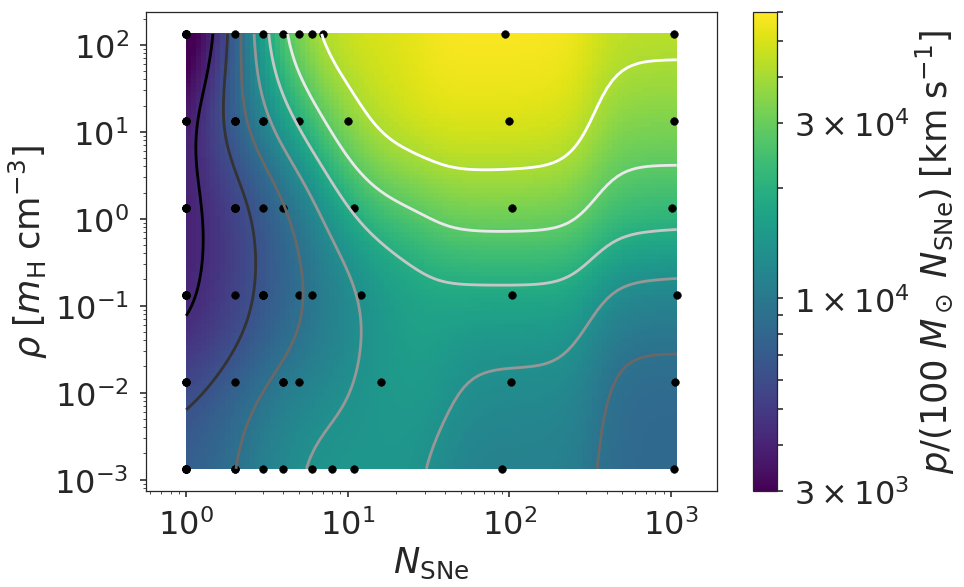

In [7]:
## Interpolate to a uniform grid in loglog space
x_out = np.logspace(np.log10(x_in).min(), np.log10(x_in).max(), num=100)
y_out = np.logspace(np.log10(y_in).min(), np.log10(y_in).max(), num=100)

spacing_x = .3
spacing_y = .6
z_out = rbf_interpolate_logloglog(x_in, y_in, z_in, x_out, y_out, spacing_x, spacing_y)

# plot: the color image
plt.pcolor(x_out, y_out, z_out, 
           cmap=plt.cm.viridis, 
           norm=LogNorm(vmin=3e3, vmax=6e4),
           edgecolors="none")

# plot: add a colorbar
plt.colorbar(
             label=r"$ p / (100$ $ M_\odot$ $ N_\mathrm{SNe}) $ $[\mathrm{km}$ $\mathrm{s}^{-1}]$",
             ticks=[3e3,4e3,5e3,6e3,7e3,8e3,9e3,1e4,2e4,3e4,4e4,5e4,6e4,7e4,8e4,9e4,1e5],
             format=ticker.FuncFormatter(momentum_tick_formatter))

# plot: add contours
plt.contour(x_out, y_out, z_out,
            levels=np.logspace(np.log10(3e3),np.log10(6e4),num=7+2)[1:-1], 
            cmap=plt.cm.Greys_r,
            locator=ticker.LogLocator(),
           )

# plot: add black scatter points to show the input points for my interpolation
plt.scatter(x_in,
            y_in,
            color="k",s=60)


# The rest is just to make it look prettier
plt.xlabel(r"$ N_\mathrm{SNe}$")
plt.ylabel(r"$ \rho $ $[m_\mathrm{H}$ $\mathrm{cm}^{-3}]$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(x_out.min()*10**-.25, x_out.max()*10**.25)
plt.ylim(y_out.min()*10**-.25, y_out.max()*10**.25)